In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/experiment_2


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentDataNE, ExperimentDataNAS
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [8]:
config_versions = {'NE': {'project': 'neuro-evolution',
                         'algorithm_version': 'bayes-neat'},
                  'NAS': {'project': 'nas',
                         'algorithm_version': 'nas'}
                  }
datasets = ['iris', 'wine', 'breast_cancer', 'titanic', 'spambase', 'mnist_downsampled']
datasets = [ 'mnist_downsampled']
# dataset = 'iris'

In [11]:
# df_versions = pd.DataFrame([['Bayesian-NEAT', 'NE', True, 'bayesian_neat_ft_21_iris'],
#                            ['NEAT', 'NE', False, 'neat_ft_21_iris'],
#                            ['Bayesian-MLP', 'NAS', True, 'bayesian_nas_final'],
# #                            ['NAS', False, 'standard_nas_final_with_reps']
#                            ['MLP', 'NAS', False, 'standard_nas_final']
#                            ], columns=['method', 'search', 'is_bayesian', 'correlation_id'])
versions_map = {}
for dataset in datasets:
    df_versions = pd.read_csv(f'./versions/mnist_downsampled-5_classes.csv')
    print(f'DATASET: {dataset}')
    print(df_versions)
    versions_map[dataset] = df_versions

DATASET: mnist_downsampled
          method search  is_bayesian  \
0  Bayesian-NEAT     NE         True   
1           NEAT     NE        False   
2   Bayesian-MLP    NAS         True   
3            MLP    NAS        False   

                                      correlation_id  
0  bayesian_neat_ft_final_v1_5_classesmnist_downs...  
1        neat_ft_final_v1_5_classesmnist_downsampled  
2                       bayesian_nas_final_5_classes  
3                       standard_nas_final_5_classes  


In [10]:
# df_versions.to_csv(f'./versions/{dataset}.csv', index=False)

In [12]:
chunks_ne = []
chunks_nas = []
for dataset, df_versions in versions_map.items():
    print(dataset)
    for index, row in df_versions.iterrows():
        method = row.method
        version = row.search
        is_bayesian = row.is_bayesian
        correlation_id = row.correlation_id
        print(method, version, is_bayesian, correlation_id)
        if isinstance(correlation_id, float):
            continue
            
        n_samples = 1000 if is_bayesian else 1
        project = config_versions[version]['project']
        algorithm_version = config_versions[version]['algorithm_version']
        print(project, algorithm_version, n_samples)
        if version == 'NE':
            experiment_data = ExperimentDataNE(correlation_ids=[correlation_id], 
                                               dataset_name=dataset, 
                                               n_samples=n_samples,
                                               project = project, 
                                               algorithm_version = algorithm_version,
                                               keep_top=1.0, 
                                               filter_checkpoint_finish=True)\
                                .process_data()
            chunk_data_ne = experiment_data.get_experiment_data()
            # stay only with the best
            chunk_data_ne = chunk_data_ne.loc[chunk_data_ne['absolute_best'] == True]
            chunk_data_ne['version'] = version
            chunk_data_ne['is_bayesian'] = is_bayesian
            chunk_data_ne['method'] = method
            chunk_data_ne['dataset'] = dataset
            chunks_ne.append(chunk_data_ne)
        elif version == 'NAS':
            experiment_data_nas = ExperimentDataNAS(correlation_ids=[correlation_id], dataset_name=dataset, n_samples=n_samples,
                                                    project=config_versions[version]['project'], 
                                                    algorithm_version=config_versions[version]['algorithm_version'],
                                                    keep_top=1.0, filter_checkpoint_finish=True)
            experiment_data_nas.process_data()
            chunk_data_nas = experiment_data_nas.experiment_data
            chunk_data_nas['version'] = version
            chunk_data_nas['is_bayesian'] = is_bayesian
            chunk_data_nas['method'] = method
            chunk_data_nas['dataset'] = dataset
            chunks_nas.append(chunk_data_nas)
        else:
            raise ValueError()
data_ne = pd.concat(chunks_ne, sort=False)
data_nas = pd.concat(chunks_nas, sort=False)
# bayesian_neat_ft_final_v1_spambase

mnist_downsampled
Bayesian-NEAT NE True bayesian_neat_ft_final_v1_5_classesmnist_downsampled
neuro-evolution bayes-neat 1000
###########
CORRELATION ID: bayesian_neat_ft_final_v1_5_classesmnist_downsampled
5 executions
Train percentage: 0.75
Random state: 63
Sum Train: 444.2998046875
Label Noise: 0.0
Sum of 10 first labels: 20
[0 3 4 3 1 2 1 4 0 2]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 63
Sum Train: 444.2998046875
Label Noise: 0.0
Sum of 10 first labels: 20
[0 3 4 3 1 2 1 4 0 2]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 3
Sum Train: 748.9120483398438
Label Noise: 0.0
Sum of 10 first labels: 25
[0 4 3 3 1 3 4 3 0 4]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 3
Sum Train: 748.9120483398438
Label Noise: 0.0
Sum of 10 first labels: 25
[0 4 3 3 1 3 4 3 0 4]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 37
Sum Train: 833.6084594726562
Label Noise: 0.0
Sum of 10 first labels: 21
[1 0 0 4 2 3 4 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

NEAT NE False neat_ft_final_v1_5_classesmnist_downsampled
neuro-evolution bayes-neat 1
###########
CORRELATION ID: neat_ft_final_v1_5_classesmnist_downsampled
10 executions
Train percentage: 0.75
Random state: 98
Sum Train: 941.8656616210938
Label Noise: 0.0
Sum of 10 first labels: 21
[3 1 3 1 4 3 0 4 0 2]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 98
Sum Train: 941.8656616210938
Label Noise: 0.0
Sum of 10 first labels: 21
[3 1 3 1 4 3 0 4 0 2]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 50
Sum Train: 508.47540283203125
Label Noise: 0.0
Sum of 10 first labels: 17
[2 2 1 2 1 1 4 0 1 3]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 50
Sum Train: 508.47540283203125
Label Noise: 0.0
Sum of 10 first labels: 17
[2 2 1 2 1 1 4 0 1 3]
Training: 3750. Testing: 1250
Train percentage: 0.75
Random state: 75
Sum Train: 593.6168823242188
Label Noise: 0.0
Sum of 10 first labels: 25
[3 0 3 4 1 2 1 3 4 4]
Training: 3750. Testing: 1250


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Sum Train: 697.45458984375
Label Noise: 0.7
Sum of 10 first labels: 17
[1 2 2 0 3 3 1 4 0 1]
Training: 3750. Testing: 1250
Sum Train: 638.957275390625
Label Noise: 0.1
Sum of 10 first labels: 30
[4 4 3 1 3 2 4 1 4 4]
Training: 3750. Testing: 1250
Sum Train: 794.7771606445312
Label Noise: 0.0
Sum of 10 first labels: 20
[0 4 0 1 3 2 4 4 1 1]
Training: 3750. Testing: 1250
Sum Train: 690.7769165039062
Label Noise: 0.1
Sum of 10 first labels: 24
[3 3 3 4 1 1 0 4 3 2]
Training: 3750. Testing: 1250
Sum Train: 752.4967651367188
Label Noise: 0.3
Sum of 10 first labels: 24
[4 0 1 4 3 0 2 4 2 4]
Training: 3750. Testing: 1250
Sum Train: 804.0706176757812
Label Noise: 0.7
Sum of 10 first labels: 25
[3 0 2 2 4 3 3 3 3 2]
Training: 3750. Testing: 1250
Sum Train: 706.4189453125
Label Noise: 0.5
Sum of 10 first labels: 17
[1 2 3 4 0 2 1 0 2 2]
Training: 3750. Testing: 1250
Sum Train: 1521.0950927734375
Label Noise: 0.1
Sum of 10 first labels: 22
[3 3 0 4 3 0 2 0 4 3]
Training: 3750. Testing: 1250
Sum T

/home/jovyan/deep_learning/standard/feed_forward.py:38: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Sum Train: 829.638427734375
Label Noise: 0.4
Sum of 10 first labels: 16
[2 1 0 3 0 0 2 3 1 4]
Training: 3750. Testing: 1250
Sum Train: 557.7268676757812
Label Noise: 0.4
Sum of 10 first labels: 19
[0 1 4 0 1 3 0 4 4 2]
Training: 3750. Testing: 1250
Sum Train: 402.4299621582031
Label Noise: 0.3
Sum of 10 first labels: 20
[1 4 3 0 3 1 4 2 0 2]
Training: 3750. Testing: 1250
Sum Train: 739.4963989257812
Label Noise: 0.5
Sum of 10 first labels: 18
[4 1 0 4 2 3 2 0 2 0]
Training: 3750. Testing: 1250
Sum Train: 1352.916259765625
Label Noise: 0.5
Sum of 10 first labels: 20
[1 3 2 3 0 0 4 2 1 4]
Training: 3750. Testing: 1250
Sum Train: 537.5860595703125
Label Noise: 0.6
Sum of 10 first labels: 18
[3 3 1 0 0 4 4 2 0 1]
Training: 3750. Testing: 1250
Sum Train: 1135.894287109375
Label Noise: 0.5
Sum of 10 first labels: 14
[1 1 4 1 0 2 2 3 0 0]
Training: 3750. Testing: 1250
Sum Train: 638.957275390625
Label Noise: 0.4
Sum of 10 first labels: 21
[4 4 3 0 3 2 0 1 0 4]
Training: 3750. Testing: 1250
Su

In [13]:
display(data_ne.head(1))
display(data_nas.head(1))

,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,loss_training,loss_testing,duration,...,mean_genome_std,accuracy,precision,recall,f1,ece,absolute_best,version,method,dataset
0,bayesian_neat_ft_final_v1_5_classesmnist_downs...,40b0d771-8f58-459d-bb65-57ec80fd6fa3,0.75,0.0,0.0,True,0.000005,1.050872,1.381918,1:02:14.093424,...,0.853242,90.08,0.901634,0.9008,0.900707,0.115225,True,NE,Bayesian-NEAT,mnist_downsampled


,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,duration,end_condition,n_parameters,...,n_connections,n_layers,f1,recall,precision,accuracy,ece,version,method,dataset
0,bayesian_nas_final_5_classes,1425c5d0-0ad3-42c1-b0b5-69c79a741edf,0.75,0.0,0.3,True,0.000005,0:03:58.920136,normal,2590,...,1260,3,0.929582,0.9296,0.93379,92.96,0.054288,NAS,Bayesian-MLP,mnist_downsampled


In [14]:
from scipy import stats
def filter_data(data, filter_noisy=False, z_score=3):
#     data = data.loc[data['f1'] >= filter_threshold]
    chunks = []
    for _, df in data.groupby(['method', 'label_noise']):
#         df[(np.abs(stats.zscore(df['f1'])) < 3).all(axis=1)]
        df = df.loc[np.abs(stats.zscore(df['f1'])) < z_score]
        chunks.append(df)
    data = pd.concat(chunks)
    if filter_noisy:
        data = data.loc[(data['noise'] == 0) &
               (data['label_noise'] == 0)]
    
    
    return data

Filter noisy executions

In [15]:
display(data_ne.shape)
display(data_nas.shape)

(10, 25)

(135, 21)

In [16]:
data_ne = data_ne.loc[(data_ne['noise'] == 0) &
                     (data_ne['label_noise'] == 0)]
data_nas = data_nas.loc[(data_nas['noise'] == 0) &
                     (data_nas['label_noise'] == 0)]

In [17]:
display(data_ne.shape)
display(data_nas.shape)

(10, 25)

(15, 21)

In [18]:
version = 1 # adaptive binning
for dataset, data_dataset in data_ne.groupby('dataset'):
    data_dataset.to_csv(f'data/data_experiment_2_ne_5_classes_{dataset}_v{version}.csv', index=False)

for dataset, data_dataset in data_nas.groupby('dataset'):
    data_dataset.to_csv(f'data/data_experiment_2_nas_5_classes_{dataset}_v{version}.csv', index=False)


In [19]:
data_ne = data_ne.loc[(data_ne['noise'] == 0) &
                     (data_ne['label_noise'] == 0)]
data_nas = data_nas.loc[(data_nas['noise'] == 0) &
                     (data_nas['label_noise'] == 0)]

In [20]:
method_order = ['MLP', 'Bayesian-MLP', 'NEAT', 'Bayesian-NEAT']

In [21]:
data = pd.concat([data_ne, data_nas])
display(data.shape)
data = filter_data(data, filter_noisy=True, z_score=4)
data.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(25, 25)

(25, 25)

In [23]:
# data.loc[data['is_bayesian'] == False, 'n_parameters'] = data.loc[data['is_bayesian'] == False, 'n_parameters'] /2
# data.loc[data['method'].isin(['MLP', 'Bayesian-MLP']), 'duration_s'] = data.loc[data['method'].isin(['MLP', 'Bayesian-MLP']), 'duration_s'] / 8 * 40

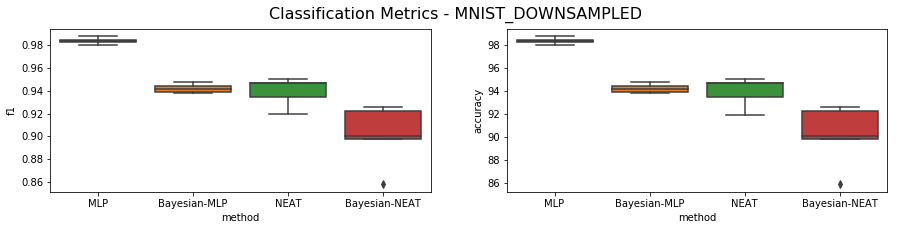

In [25]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle(f'Classification Metrics - {dataset.upper()}', fontsize=16)

    sns.boxplot(data=data_dataset, x='method', y='f1', ax=ax1, order=method_order)
    sns.boxplot(data=data_dataset, x='method', y='accuracy', ax=ax2, order=method_order)
    plt.savefig(f'./experiment_2_metrics_5_classes{dataset}.png')
    plt.show()

In [28]:
metrics_stats = data.groupby(['dataset', 'method']).agg({'f1': [np.mean, np.std],
                                                        'accuracy': [np.mean, np.std]})
metrics_stats

f1           accuracy          
                                     mean       std     mean       std
dataset           method                                              
mnist_downsampled Bayesian-MLP   0.942160  0.004016   94.224  0.389461
                  Bayesian-NEAT  0.900692  0.026985   90.128  2.703834
                  MLP            0.983851  0.002091   98.384  0.209295
                  NEAT           0.939491  0.012885   93.968  1.299354

In [30]:
def sort_df_by_dataset(df):
    df = df.merge(df_dataset_sorting, on='dataset').sort_values('order', ascending=True).drop(columns=['order'])
    return df

In [32]:
f1 = pd.pivot_table(data=metrics_stats['f1'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
f1 = f1[['dataset'] + method_order]
# f1 = sort_df_by_dataset(f1)
display(f1)
f1.to_latex('mean_f1-5-classes.txt', index=False)

method,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
0,mnist_downsampled,0.983851,0.94216,0.939491,0.900692


In [33]:
accuracy = pd.pivot_table(data=metrics_stats['accuracy'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
accuracy = accuracy[['dataset'] + method_order]
# f1 = sort_df_by_dataset(f1)
display(accuracy)
accuracy.to_latex('mean_accuracy-5-classes.txt', index=False)

method,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
0,mnist_downsampled,98.384,94.224,93.968,90.128
